# 1. Set Up

In [1]:
!spack find -p tfel
!export PATH=/mofem_install/jupyter/thomas/um_view/bin:$PATH 
!echo $PATH
!read_med

-- linux-ubuntu20.04-x86_64 / gcc@9.4.0 -------------------------
tfel@4.0.0  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx
tfel@4.0.0  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc
==> 2 installed packages
/mofem_install/um_view/bin:/mofem_install/jupyter/thomas/.local/bin:/mofem_install/jupyter/thomas/.vscode/cli/servers/Stable-384ff7382de624fb94dbaf6da11977bba1ecd427/server/bin/remote-cli:/mofem_install/um_view/bin:/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/py-numpy-1.26.1-ue7volt2h7awnoymiyxjzriegzyc3rr5/bin:/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/python-3.11.6-a6ce7p54ivs64b5eohmbbwye227i4642/bin:/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/xz-5.4.1-2mwenxme6zkcsocqiwfszexdhxo7zqwt/bin:/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwm

In [2]:
# %env LD_LIBRARY_PATH=/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib

In [3]:
!echo "$(spack find -p tfel | awk '/\/mofem_install\// {print $NF "/lib"}')"

/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib
/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc/lib


In [4]:
import math
import os
import re
import sys
import time
import json
from pathlib import Path
import subprocess
import zipfile
import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import gmsh
from scipy import optimize
from scipy.optimize import curve_fit, least_squares

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import mesh_create_test_2D as mshcrte
import custom_models as cm
import utils as ut
import plotting


def set_display_configurations(): pass
    # from matplotlib.colors import ListedColormap
    # pv.set_plot_theme("document")

    # plt.rcParams['figure.figsize'] = [12, 9]
    # plt.rcParams['figure.dpi'] = 300
    # plt.rcParams['font.family'] = "DejaVu Serif"
    # plt.rcParams['font.size'] = 20

    # from pyvirtualdisplay import Display
    # display = Display(backend="xvfb", visible=False, size=(800, 600))
    # display.start()
    
set_display_configurations()
os.chdir('/mofem_install/jupyter/thomas/mfront_example_test')
    


# 2. Simulation Parameters

In [5]:
# todo implement a log that remembers if there is a mesh previously generated, and switch if to generate a new mesh
#in MPa
def initialize_parameters():
    params = cm.AttrDict()
    params.tester = cm.TestAttr(
        preferred_model= cm.PropertyTypeEnum.von_mises,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.3),
            cm.PropertyTypeEnum.von_mises: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.3,HardeningSlope = 10, YieldStress = 100),
            cm.PropertyTypeEnum.drucker_prager: cm.DruckerPragerProperties(youngs_modulus=96, poisson_ratio=0.3, d = 150, beta = 0.6, pa = 0.01, pb = 0.05),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
            }, 
        
    )
 
    # params.prescribed_force = cm.ForceBoundaryCondition(fx=0,fy=0,fz=5000)
    params.prescribed_disp = cm.SurfaceBoundaryCondition(disp_ux=0, disp_uy=0 ,disp_uz=0)
    params.nproc = 8 # number of processors/cores used
    params.order = 2 #order of approximation functions

    # params.time_step = 0.05 # [s]
    params.time_step = 10e-5 # [s]
    params.final_time = 1 # [s]

    return params

In [6]:
params = initialize_parameters()

# 3. Log paths and meta

In [7]:
def days_since_epoch():
    epoch_date = time.strptime("2024-08-17", "%Y-%m-%d")
    epoch_seconds = time.mktime(epoch_date)
    # Get the current time
    current_seconds = time.time()
    # Calculate days since the epoch
    days_since_epoch = int((current_seconds - epoch_seconds) // (24 * 3600))
    return days_since_epoch

def log_sim_entry(params):
    params.global_log_file = params.wk_dir / "simulations/simulation_log.json"
    
    # Load existing logs if the log file exists
    if params.global_log_file.exists():
        with open(params.global_log_file, 'r') as f:
            logs = json.load(f)
    else:
        logs = {}

    # Create the params dictionary for the log entry
    params_dict = {
        "test_volume": params.tester.model_dump(serialize_as_any=True),
        "prescribed_force": params.prescribed_force.model_dump() if getattr(params, 'prescribed_force', None) else None,
        "prescribed_disp": params.prescribed_disp.model_dump() if getattr(params, 'prescribed_disp', None) else None,
    }

    # Filter simulations for today and count simulations with the same parameters
    params.prior_sims_with_same_params = [log for log in logs.values() if log['params'] == params_dict]
    # params.prior_sims_with_same_params_no = len(params.prior_sims_with_same_params)
    # params.new_sim_number_with_same_params = params.prior_sims_with_same_params_no + 1
    params.new_sim_number = len(logs) + 1
    # Determine simulation number for today prior to this simulation
    params.prior_sims_today = len([log for log in logs.values() if log['date_of_sim'] == params.date_of_sim])
    params.new_sim_number_today = params.prior_sims_today + 1

    # Create the log entry as a dictionary
    log_entry = {
        "days_since_epoch": params.days_since_epoch,
        "sim_number_of_the_day": params.new_sim_number_today,
        "date_of_sim": params.date_of_sim,
        "time_of_sim": params.time_of_sim,
        # "sim_number_with_same_params": params.new_sim_number_with_same_params,
        "params": params_dict,
    }

    # Add the new entry to the logs
    logs[f"{params.new_sim_number}"] = log_entry
    log_dir = params.wk_dir / "simulations"
    log_dir.mkdir(parents=True, exist_ok=True)
    
    if not os.path.exists(params.global_log_file):
        with open(params.global_log_file, 'w'): pass
    # Write the logs back to the JSON file
    with open(params.global_log_file, 'w') as f:
        json.dump(logs, f, indent=4)

    print(f"Simulation #{params.new_sim_number_today} for the day.")
    # print(f"Simulation #{params.new_sim_number_with_same_params} with the same parameters.")

    # if params.prior_sims_with_same_params_no > 0:
    #     # Get the datetime of the previous simulation
    #     previous_simulation = params.prior_sims_with_same_params[-1]
    #     print(f"Previous simulation with the same parameters was run on: day {previous_simulation['days_since_epoch']} simulation {previous_simulation['sim_number_today']}")
    return params

def initialize_paths(params):

    params.simulation_name = f"test_day_{params.days_since_epoch}_sim_{params.new_sim_number_today}_{params.time_of_sim}"
    params.mesh_name = f"test_day_{params.days_since_epoch}_sim_{params.new_sim_number_today}"

    # Continue with the rest of the simulation setup
    params.data_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/simulations/{params.simulation_name}")
    params.data_dir.mkdir(parents=True, exist_ok=True)

    params.template_sdf_file = params.wk_dir / f"src/template_sdf.py"
    params.sdf_file = params.wk_dir / f"src/sdf.py"


    params.med_filepath = params.data_dir / f"{params.mesh_name}.med"
    params.h5m_filepath = params.data_dir / f"{params.mesh_name}.h5m"
    params.vtk_filepath = params.data_dir / f"{params.mesh_name}.vtk"
    params.csv_filepath = params.data_dir / f"{params.mesh_name}.csv"
    params.part_file = os.path.splitext(params.h5m_filepath)[0] + "_" + str(params.nproc) + "p.h5m"

    params.read_med_initial_log_file = params.data_dir / f"{params.mesh_name}_read_med.log"

    # params.bc_time_history = params.data_dir / "disp_time.txt"
    params.config_file = params.data_dir / "bc.cfg"
    params.log_file = params.data_dir /  f"result_{params.mesh_name}.log"
    if not os.path.exists(params.log_file):
        with open(params.log_file, 'w'): pass

    return params



# sys.exit()

In [8]:
params.days_since_epoch = days_since_epoch()
    
params.time_of_sim = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
params.date_of_sim = time.strftime("%Y_%m_%d", time.localtime())

# File paths and directories
params.wk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test")
params = log_sim_entry(params)

params = initialize_paths(params)
params.user_name = !whoami
params.user_name = params.user_name[0]
params.um_view = f"/mofem_install/jupyter/{params.user_name}/um_view"

Simulation #4 for the day.


# 4. Generate the mesh

In [9]:
geo = mshcrte.draw_mesh(params)
params.physical_groups = mshcrte.add_physical_groups(params, geo)
params.physical_groups = mshcrte.check_block_ids(params,params.physical_groups)
params.physical_groups = mshcrte.generate_config(params,params.physical_groups)
mshcrte.inject_configs(params)
mshcrte.partition_mesh(params)

╭────────────────╮
│  DRAWING MESH  │
╰────────────────╯
Done, taken Wall Time: 0.00 seconds, CPU Time: 0.00 seconds
╭──────────────────────────────────╮
│  ADDING PHYSICAL GROUPS TO MESH  │
╰──────────────────────────────────╯
Done, taken Wall Time: 0.01 seconds, CPU Time: 0.01 seconds
╭──────────────────────╮
│  CHECKING BLOCK IDS  │
╰──────────────────────╯
{'test_day_64_sim_4': 1, 'FIX_ALL': 2, 'FIX_X_0': 3, 'VOLUME': 4}
Done, taken Wall Time: 0.28 seconds, CPU Time: 0.00 seconds
╭───────────────────────────╮
│  GENERATING CONFIG FILES  │
╰───────────────────────────╯
Done, taken Wall Time: 0.00 seconds, CPU Time: 0.00 seconds
╭───────────────────────────────────────╮
│  INJECTING CONFIG FILE with read_med  │
╰───────────────────────────────────────╯


[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-10-20 17:31:27
[0] <inform> UTC time: 2024-10-20 17:31:27
[0] <inform> [MED] Reading MED file V4.1.0 using MED library V4.1.0
[0] <inform> [MED] Check mesh test_day_64_sim_4 nsteps 1
[0] <inform> [MED] Reading mesh test_day_64_sim_4 nsteps 1
[0] <inform> [MED] Read number of nodes 98
[0] <inform> [MED] Reading elements 24 of type Edge number of nodes 2
[0] <inform> [MED] Reading elements 162 of type Tri number of nodes 3
[0] <inform> [read_med] Print all meshsets (old and added from meshsets configurational file)
[0] <inform> [read_med] meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name test_day_64_sim_4
[0] <inform> [read_med] meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FIX_ALL                        
[0] <inform> [read_med] meshset 12682136550675316739 type BL

Done, taken Wall Time: 0.23 seconds, CPU Time: 0.00 seconds
╭─────────────────────────────────────╮
│  PARTITIONING MESH with mofem_part  │
╰─────────────────────────────────────╯
Done, taken Wall Time: 0.28 seconds, CPU Time: 0.00 seconds


[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-10-20 17:31:27
[0] <inform> UTC time: 2024-10-20 17:31:27
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name test_day_64_sim_4
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FIX_ALL                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name FIX_X_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 4 name VOLUME                         
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 104 name MFRONT_MAT_4
[0] <inform> [mofem_part] meshset 12682136550675316737 type

# 5. Running the analysis and export to .vtk file format

In [10]:
mshcrte.mofem_compute(params)

╭─────────────╮
│  COMPUTING  │
╰─────────────╯
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-10-20 17:31:28
[0] <inform> UTC time: 2024-10-20 17:31:28
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name test_day_64_sim_4
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316752 type BLOCKSET UNKNOWNNAME msId 2 name FIX_ALL                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name FIX_X_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 4 name VOLUME                         
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 104 name MFRONT_MAT_4
[0] <inform

In [11]:
mshcrte.export_to_vtk(params)

╭────────────────────────────────╮
│  CONVERTING FROM .htm TO .vtk  │
╰────────────────────────────────╯
Conversion to VTK successful.
Moved out_mi_891.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_64_sim_4_2024_10_20_17_31_26
Moved out_mi_890.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_64_sim_4_2024_10_20_17_31_26
Moved out_mi_89.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_64_sim_4_2024_10_20_17_31_26
Moved out_mi_889.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_64_sim_4_2024_10_20_17_31_26
Moved out_mi_888.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_64_sim_4_2024_10_20_17_31_26
Moved out_mi_887.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_64_sim_4_2024_10_20_17_31_26
Moved out_mi_886.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_64_sim_4_2024_10_20_17_31_2

# 6. Visualize final time step .vtk file

/mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_64_sim_4_2024_10_20_17_31_26/out_mi_1000.vtk


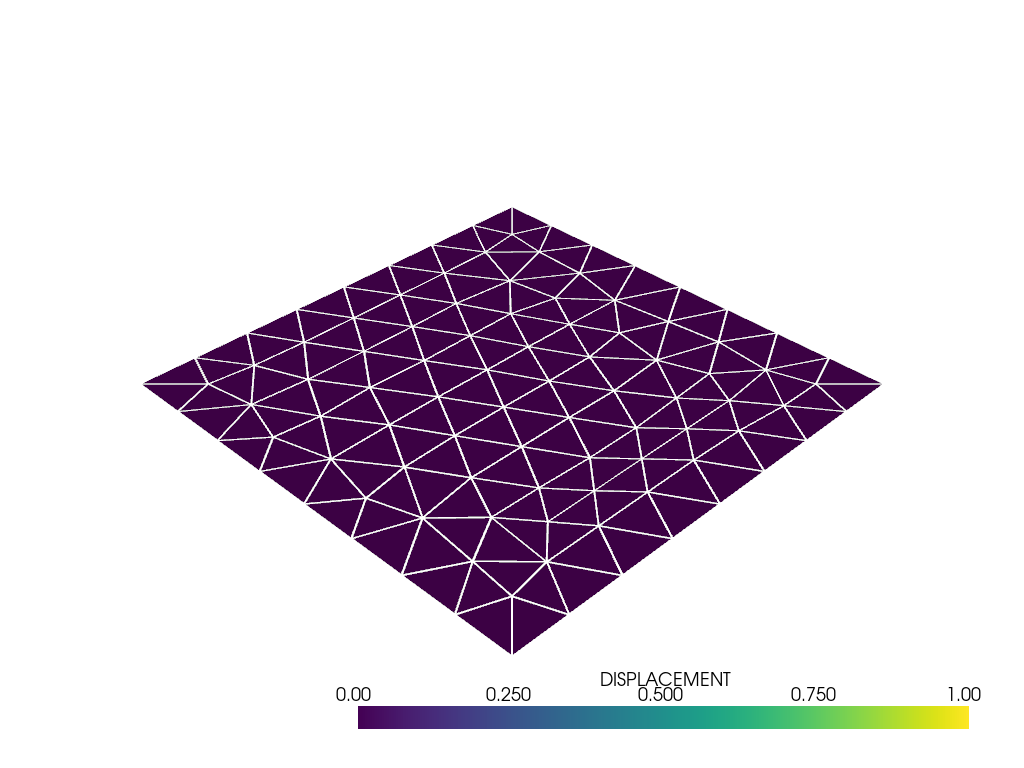

In [15]:
import pyvista as pv
pv.set_plot_theme("document")

from pyvirtualdisplay import Display
display = Display(backend="xvfb", visible=False, size=(1024, 768))
display.start()
vtk_files = subprocess.run(f"ls -c1 {params.data_dir}/*.vtk | sort -V", shell=True, text=True, capture_output=True)
if vtk_files.returncode == 0:
    files = [vtk_file for vtk_file in vtk_files.stdout.splitlines()]
    final_file = files[-1]
    mesh = pv.read(final_file)
    mesh=mesh.shrink(0.95) 
    warp_factor = 1.0
    # mesh = mesh.warp_by_vector(vectors="U", factor = warp_factor)
    # show_field = "STRESS"
    show_field = "DISPLACEMENT" # U: displacement
    # show_field = "STRAIN" # U: displacement
    
    if mesh.point_data[show_field].shape[1] > 3:
        cmap = "Spectral"
    p = pv.Plotter(notebook=True)
    p.add_mesh(mesh, scalars=show_field)
    # p.camera_position = [(-10, 0, 10), (0.0, 0.0, 0.0), (0.0, 1.0, 0.0)]
    p.camera_position = 'iso'
    p.show(jupyter_backend='ipygany')